# Test Corr Models

In [31]:
import numpy as np
import pandas as pd
from copy import deepcopy
import yfinance as yf

import new_corr_models as CM
import backtesting as BT
import plots as IP
import data_download as dd

### Data 

In [32]:
# Define shares directly (tickers inferred from index)
shares = pd.Series({
    "AAPL": 10,
    "MSFT": 9,
    "NVDA": 80,
    "GOOGL": 6,
    "JPM": 9
})

# Download prices for the tickers in 'shares'
tickers = shares.index.tolist()
prices = dd.get_raw_prices(tickers, start="2020-01-01")

# Convert prices to base currency (e.g. CHF)
prices_converted = dd.convert_to_base(prices, base="CHF")

# Create portfolio with monetary positions
x_matrix = dd.create_portfolio(prices_converted, shares)

# Compute returns and summary stats
returns, mean_returns, covariance_matrix = dd.summary_statistics(x_matrix)

# Display
final_value = x_matrix.sum(axis=1).iloc[-1]
print(f"\nPortfolio final value in CHF: {final_value:.2f}")
print("\nSample of daily returns:\n", returns.head())
print("\nMean returns (daily, in CHF):\n", mean_returns)
print("\nCovariance matrix (in CHF):\n", covariance_matrix)


[currency detection] AAPL: USD
[currency detection] GOOGL: USD
[currency detection] JPM: USD
[currency detection] MSFT: USD
[currency detection] NVDA: USD
[fx download] Downloading FX pairs: CHFUSD=X
[conversion] AAPL: USD → CHF via CHFUSD=X
[conversion] GOOGL: USD → CHF via CHFUSD=X
[conversion] JPM: USD → CHF via CHFUSD=X
[conversion] MSFT: USD → CHF via CHFUSD=X
[conversion] NVDA: USD → CHF via CHFUSD=X

Portfolio final value in CHF: 17117.00

Sample of daily returns:
                 AAPL     GOOGL       JPM      MSFT      NVDA
Date                                                        
2020-01-03 -0.005935 -0.001427 -0.009422 -0.008675 -0.012243
2020-01-06  0.008259  0.026950 -0.000507  0.002873  0.004483
2020-01-07 -0.007756 -0.004993 -0.020016 -0.012157  0.009002
2020-01-08  0.016432  0.007461  0.008145  0.016275  0.002217
2020-01-09  0.025847  0.015056  0.008178  0.017060  0.015543

Mean returns (daily, in CHF):
 AAPL     0.000911
GOOGL    0.000784
JPM      0.000709
MSFT     0

In [33]:
x_matrix.head()

,AAPL,GOOGL,JPM,MSFT,NVDA
Date,,,,,
2020-01-02,702.606709,395.369114,1051.287379,1332.615917,462.245240
2020-01-03,698.436792,394.804896,1041.381651,1321.055578,456.586079
2020-01-06,704.204973,405.444898,1040.853404,1324.851330,458.632900
2020-01-07,698.743246,403.420513,1020.019952,1308.745119,462.761690
2020-01-08,710.225246,406.430346,1028.327574,1330.044382,463.787534


In [34]:
missing_values = x_matrix.isnull().any().any()
print(f"Does x_matrix have missing values? {missing_values}")

Does x_matrix have missing values? False


In [35]:
# Run MA Correlation VaR
x_ma = deepcopy(x_matrix)
result_ma= CM.var_corr_moving_average_param(x_ma)

# Run RiskMetrics Correlation VaR
x_rm = deepcopy(x_matrix)
result_rm = CM.var_corr_ewma_param(x_rm)


In [36]:
result_ma.head()

,Returns,Volatility,VaR,VaR Monetary,VaR Violation
2020-01-31,-0.029341,0.012952,0.030131,120.713456,False
2020-02-03,0.009288,0.012880,0.029962,121.135268,False
2020-02-04,0.024519,0.013853,0.032227,133.447452,False
2020-02-05,0.010696,0.013616,0.031675,132.555069,False
2020-02-06,0.017510,0.013850,0.032220,137.185813,False


In [37]:
result_rm.head()

,Returns,Volatility,VaR,VaR Monetary,VaR Violation
2020-01-03,-0.008070,0.017924,0.041697,163.129750,False
2020-01-06,0.005612,0.017433,0.040555,159.543941,False
2020-01-07,-0.010169,0.017111,0.039805,154.988614,False
2020-01-08,0.011616,0.016826,0.039142,154.173076,False
2020-01-09,0.015974,0.016780,0.039036,156.207075,False


In [38]:
# Apply volatility-based ES to the MA VaR result
result_ma = CM.es_correlation(result_ma, confidence_level=0.99)

# Same for RiskMetrics
result_rm = CM.es_correlation(result_rm, confidence_level=0.99)

In [39]:
result_ma.head()

,Returns,Volatility,VaR,VaR Monetary,VaR Violation,ES,ES Monetary
2020-01-31,-0.029341,0.012952,0.030131,120.713456,False,0.034520,138.297123
2020-02-03,0.009288,0.012880,0.029962,121.135268,False,0.034327,138.780379
2020-02-04,0.024519,0.013853,0.032227,133.447452,False,0.036922,152.886011
2020-02-05,0.010696,0.013616,0.031675,132.555069,False,0.036289,151.863640
2020-02-06,0.017510,0.013850,0.032220,137.185813,False,0.036913,157.168919


In [40]:
result_rm.head()

,Returns,Volatility,VaR,VaR Monetary,VaR Violation,ES,ES Monetary
2020-01-03,-0.008070,0.017924,0.041697,163.129750,False,0.047771,186.891967
2020-01-06,0.005612,0.017433,0.040555,159.543941,False,0.046463,182.783832
2020-01-07,-0.010169,0.017111,0.039805,154.988614,False,0.045603,177.564957
2020-01-08,0.011616,0.016826,0.039142,154.173076,False,0.044844,176.630623
2020-01-09,0.015974,0.016780,0.039036,156.207075,False,0.044722,178.960903



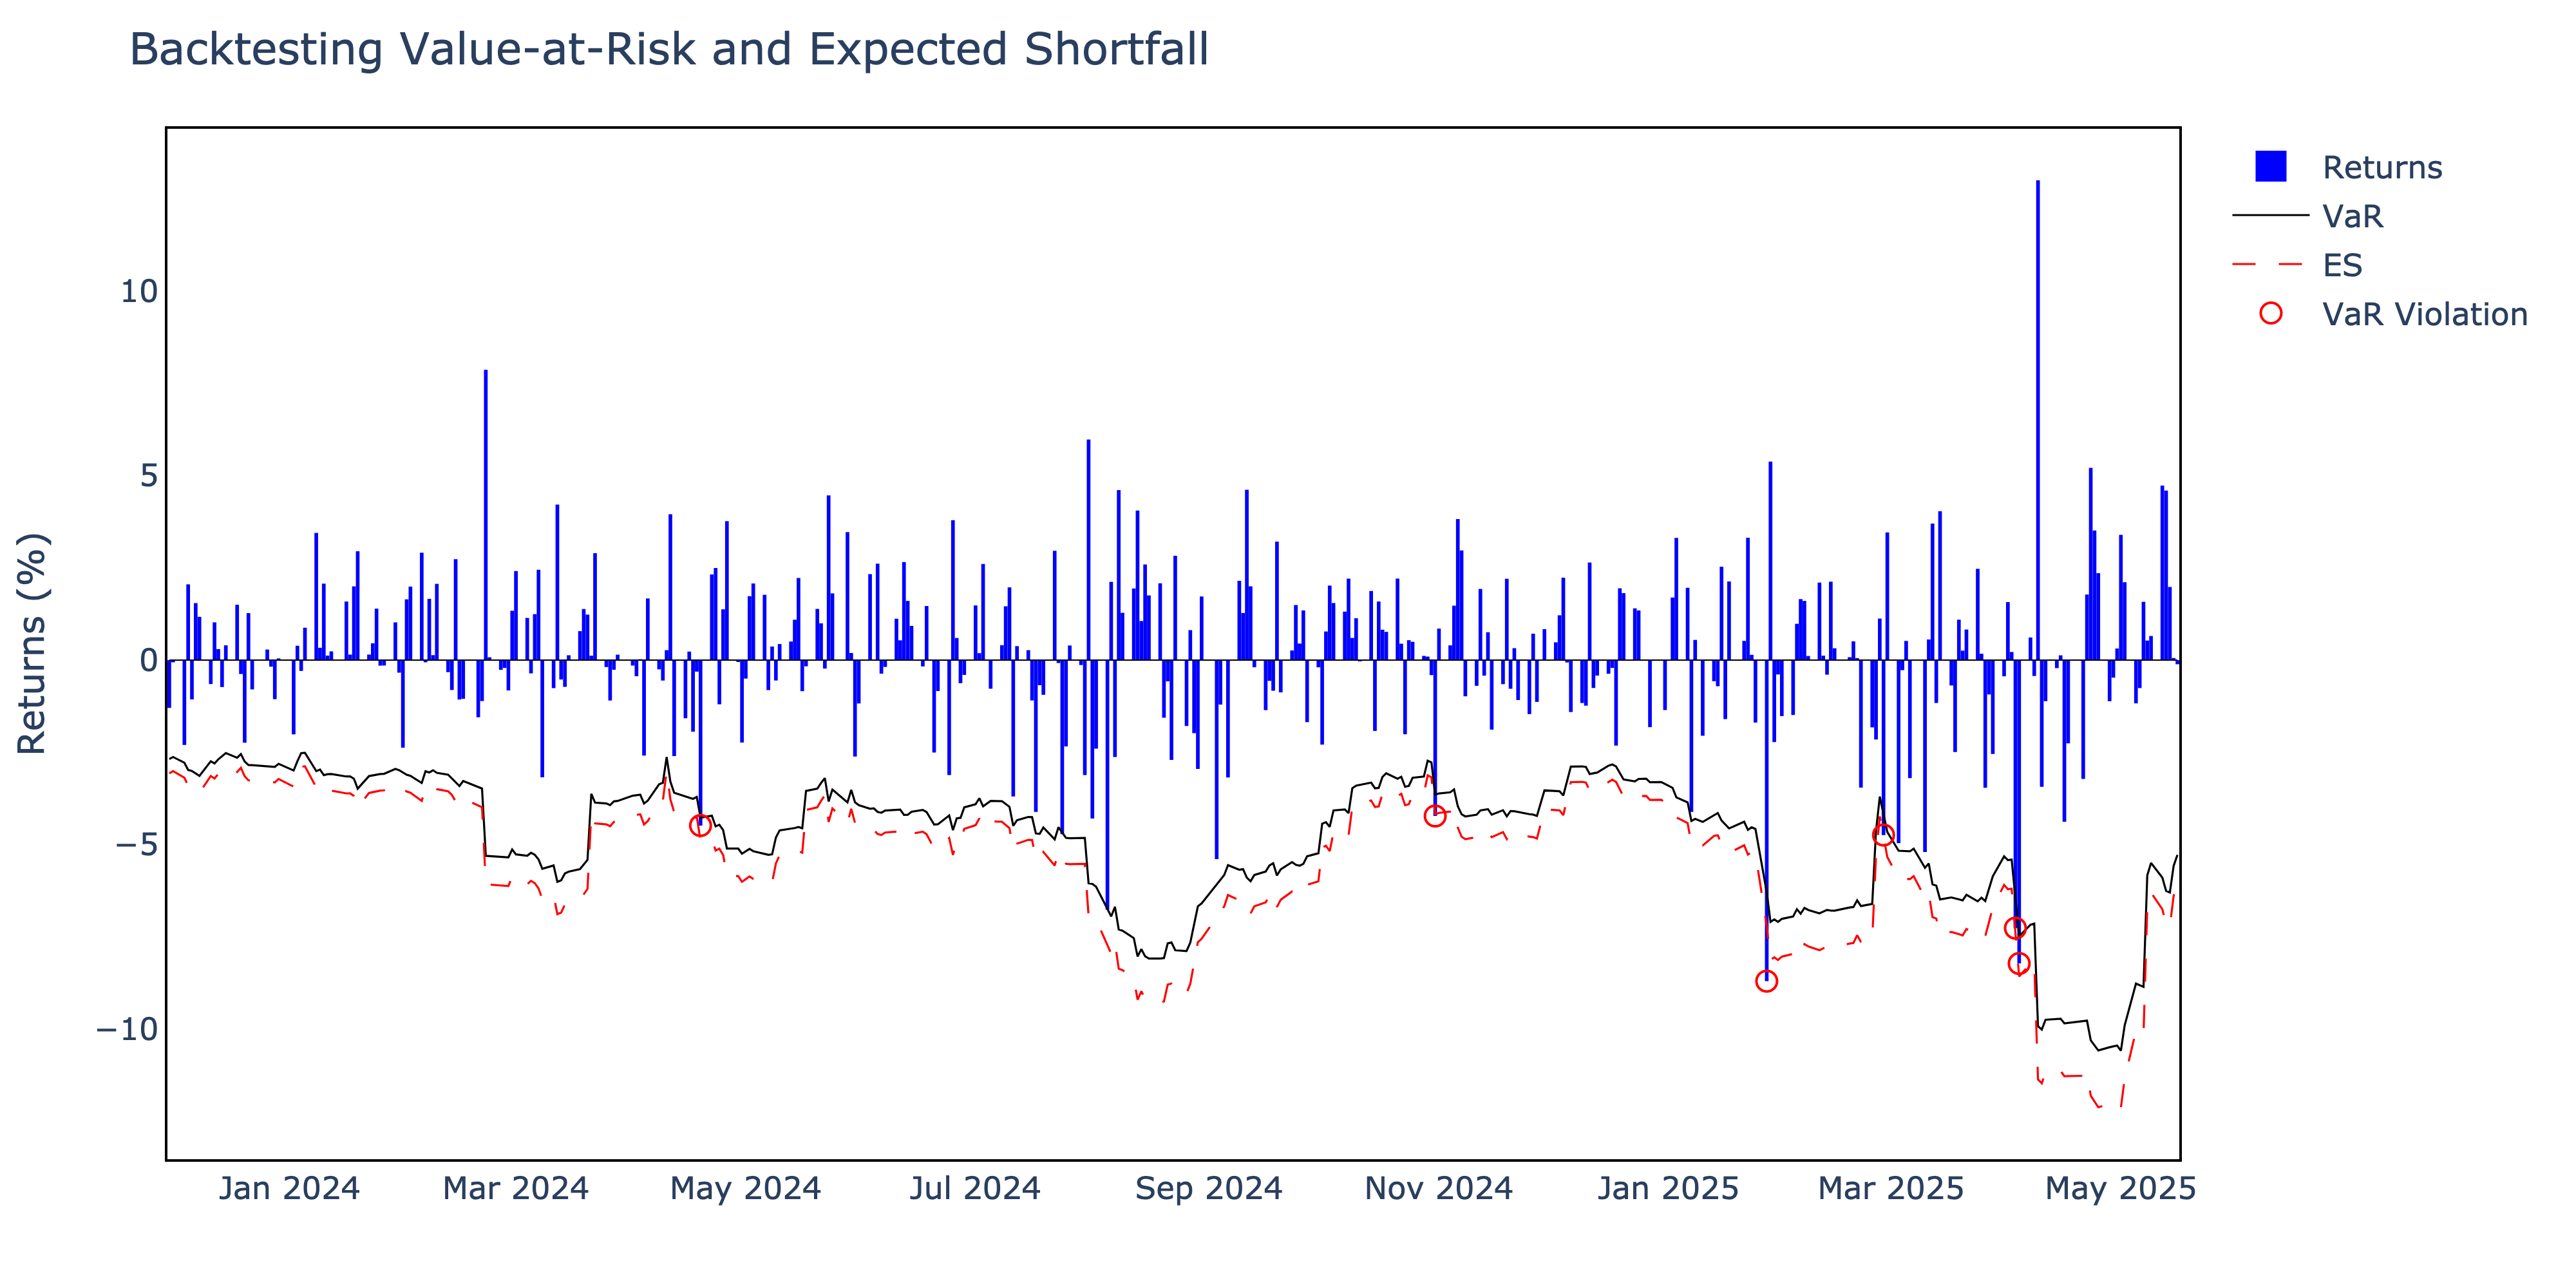


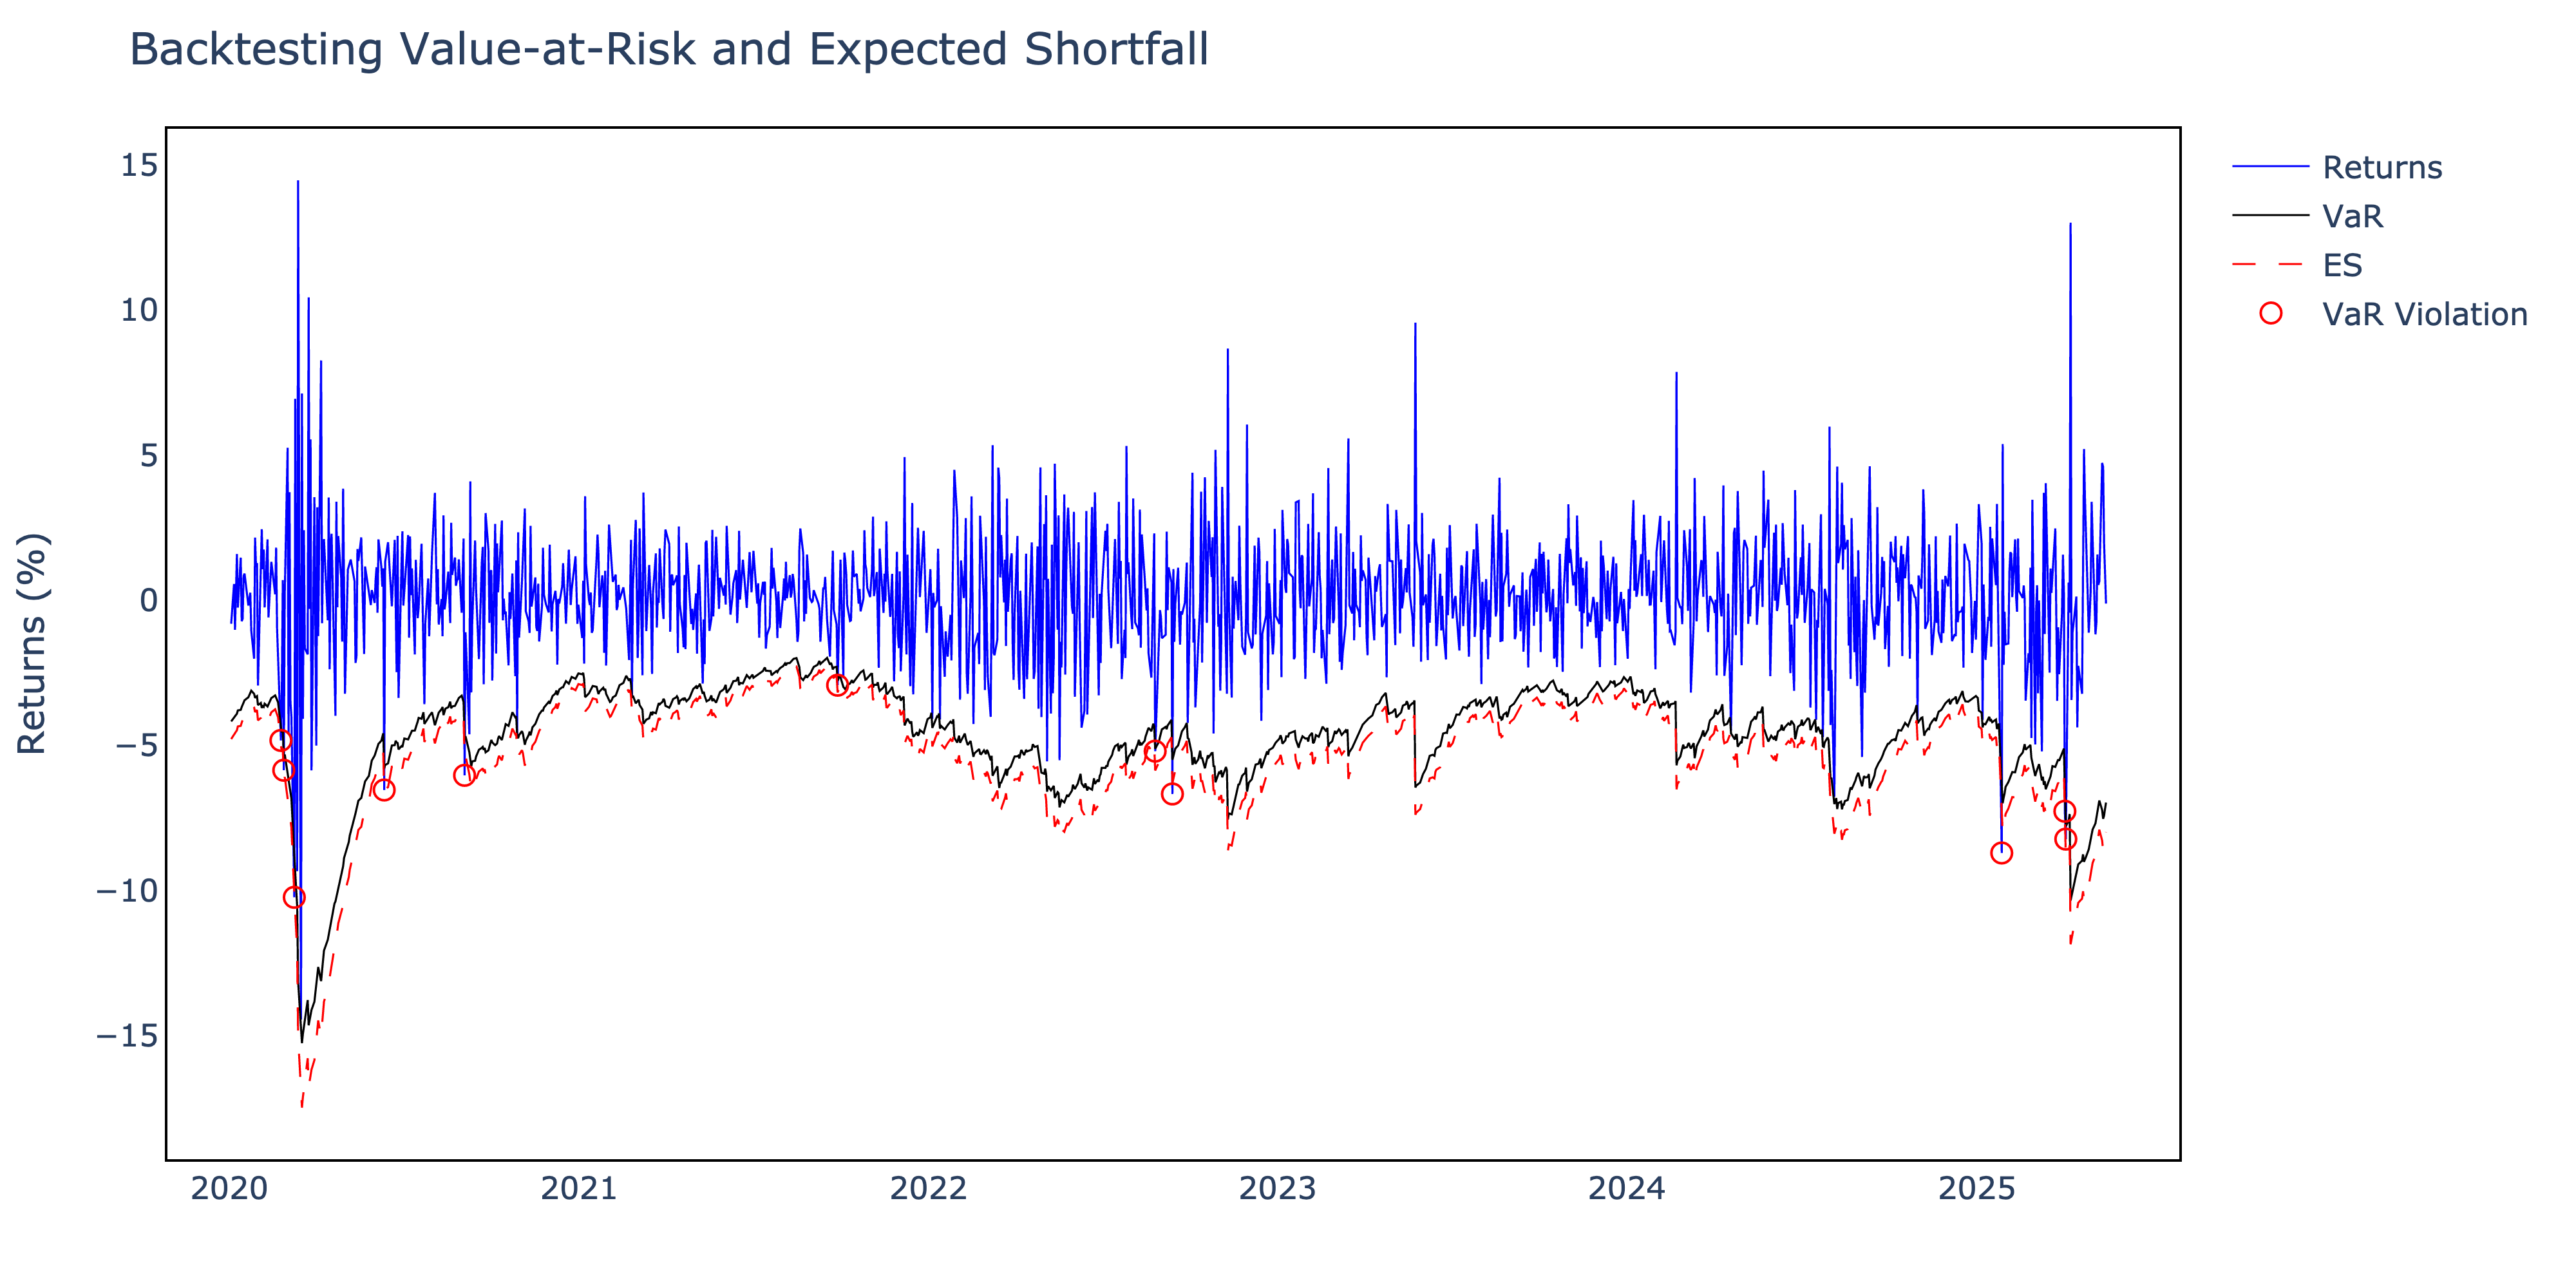

In [41]:
# Plot MA model results
fig_ma_es = IP.plot_backtest(result_ma, subset=("2023-11-30", "2025-11-30"), interactive=False)

# Plot RiskMetrics model results
fig_rm_es = IP.plot_backtest(result_rm, interactive=False)


In [42]:
violations_ma, rate_ma = BT.count_violations(result_ma)

print("== MA Correlation VaR Backtest ==")
print(f"Total Violations: {violations_ma}")
print(f"Violation Rate: {100*rate_ma:.2f}%")

== MA Correlation VaR Backtest ==
Total Violations: 15
Violation Rate: 1.13%


In [43]:
violations_rm, rate_rm = BT.count_violations(result_rm)

print("== RiskMetrics Correlation VaR Backtest ==")
print(f"Total Violations: {violations_rm}")
print(f"Violation Rate: {100*rate_rm:.2f}%")

== RiskMetrics Correlation VaR Backtest ==
Total Violations: 11
Violation Rate: 0.81%


In [44]:
fig_ma_vol = IP.plot_volatility(result_ma["Volatility"])
fig_rm_vol = IP.plot_volatility(result_rm["Volatility"])